<a href="https://www.kaggle.com/bashar54h/vgg16-xgboost-binary?scriptVersionId=89433282" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.applications import VGG16
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from glob import glob
import os
import pickle

In [2]:
def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
    img_gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     img_gs = img_gs.astype(np.uint16)
    img_clahe = clahe.apply(img_gs)
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
#     img_clahe = img_clahe.astype(np.float32)
    return img_clahe

In [3]:
ds = '../input/liver-binary/LiverBinary/Data2'
image_shape = (224,224)
images = []
labels = []
for directory_path in glob(ds+'/*'):
    label = directory_path.split('/')[-1]
    for img_path in glob(os.path.join(directory_path,'*.bmp')):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, image_shape)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = CLAHE(img)
        images.append(img)
        labels.append(label)

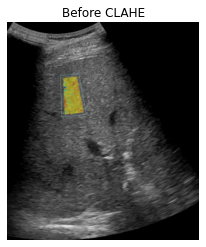

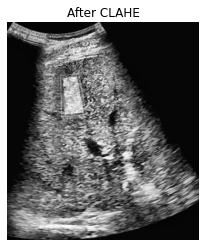

In [5]:
im = cv2.imread('../input/liver-binary/LiverBinary/Data2/abnormal/190.bmp')
plt.axis('off')
plt.title('Before CLAHE')
plt.imshow(im)
plt.show()
plt.axis('off')
plt.title('After CLAHE')
plt.imshow(CLAHE(im))
plt.show()

In [6]:
images = np.array(images)
labels = np.array(labels)
encoder = preprocessing.LabelEncoder()
labels = encoder.fit_transform(labels)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.05, random_state=101,shuffle=True)

In [8]:
VGG_model = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(*image_shape, 3))

for layer in VGG_model.layers:
    layer.trainable = False

VGG_model.summary() 

2022-03-06 15:55:10.746006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 15:55:10.864325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 15:55:10.865491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 15:55:10.867188: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [9]:
x_train_features=VGG_model.predict(x_train)
x_train_features = x_train_features.reshape(x_train_features.shape[0], -1)

x_test_features = VGG_model.predict(x_test)
x_test_features = x_test_features.reshape(x_test_features.shape[0],-1)

2022-03-06 15:55:14.666401: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-06 15:55:16.025911: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [10]:
model = xgb.XGBClassifier(use_label_encoder=False,n_estimators=300)
eval_set = [(x_train_features, y_train), (x_test_features, y_test)]
model.fit(x_train_features, y_train, 
          eval_metric=["error", "auc"],
          eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

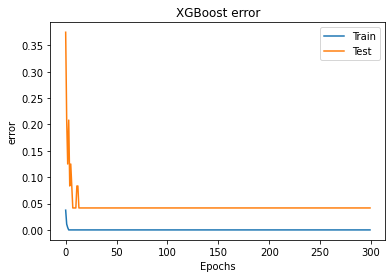

In [11]:
results = model.evals_result()
plt.xlabel('Epochs')
plt.ylabel('error')
plt.title('XGBoost error')
epochs = len(results['validation_0']['error'])
plt.plot(range(epochs), results['validation_0']['error'], label='Train')
plt.plot(range(epochs), results['validation_1']['error'], label='Test')
plt.legend()
plt.show()

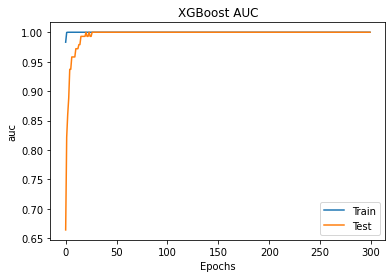

In [12]:
results = model.evals_result()
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.title('XGBoost AUC')
epochs = len(results['validation_0']['auc'])
plt.plot(range(epochs), results['validation_0']['auc'], label='Train')
plt.plot(range(epochs), results['validation_1']['auc'], label='Test')
plt.legend()
plt.show()

              precision    recall  f1-score   support

    abnormal       1.00      0.91      0.95        11
      normal       0.93      1.00      0.96        13

    accuracy                           0.96        24
   macro avg       0.96      0.95      0.96        24
weighted avg       0.96      0.96      0.96        24



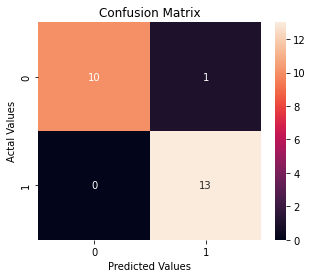

In [13]:
prediction = model.predict(x_test_features)
prediction = encoder.inverse_transform(prediction)
truth = encoder.inverse_transform(y_test)

print(classification_report(truth,prediction))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(truth,prediction), annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [14]:
file = open('binary_model.pkl', 'wb')
pickle.dump(model, file)
file.close()

In [15]:
file = open('binary_model.pkl', 'rb')
binary_model = pickle.load(file)
file.close()

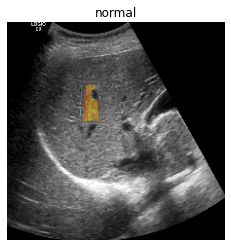

In [32]:
image_for_test = '../input/liver-binary/LiverBinary/Data2/normal/102.bmp'
image_for_test = cv2.imread(image_for_test, cv2.IMREAD_COLOR)       
image_for_test = cv2.resize(image_for_test, image_shape)
plt.axis('off')
plt.imshow(image_for_test)
image_for_test = CLAHE(image_for_test)
image_for_test = tf.expand_dims(image_for_test,0)
image_for_test_features = VGG_model.predict(image_for_test)
image_for_test_features = image_for_test_features.reshape(image_for_test_features.shape[0], -1)
test_label = binary_model.predict(image_for_test_features)
test_label = encoder.inverse_transform(test_label)

plt.title(test_label.item())
plt.show()